In [1]:
import time

import statistics 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import scikitplot as skplt

#confusion matrix
from sklearn.metrics import confusion_matrix,plot_confusion_matrix


from sklearn.tree import export_graphviz
#import graphviz
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

## Load dataset

In [2]:
df = pd.read_csv("dataset/tennis_players.csv", skipinitialspace=True, sep=',', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 3885
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2072 non-null   object 
 1   ratio                  2072 non-null   float64
 2   num_matches_2016-2019  2072 non-null   float64
 3   ratio_2016-2019        2072 non-null   float64
 4   num_matches_2020-2021  2072 non-null   float64
 5   ratio_2020-2021        2072 non-null   float64
 6   hand                   2072 non-null   object 
 7   gender                 2072 non-null   object 
 8   ioc                    2072 non-null   object 
 9   birth                  2072 non-null   float64
 10  ht                     2072 non-null   float64
 11  minutes                2072 non-null   float64
 12  perc_ace               2072 non-null   float64
 13  serv_won_tot_seve      2072 non-null   float64
 14  bpFaced                2072 non-null   float64
 15  perc

### Adding player's rank

In [3]:
df_rank = pd.read_csv('../Task1/dataset/matches_datacleaning.csv', index_col = 0)
pd.set_option('display.max_columns', None) # to visualize all the columns
df_rank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181501 entries, 0 to 185763
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          181501 non-null  object 
 1   tourney_name        181501 non-null  object 
 2   surface             181354 non-null  object 
 3   draw_size           181501 non-null  float64
 4   tourney_level       181501 non-null  object 
 5   tourney_date        181501 non-null  object 
 6   match_num           181501 non-null  float64
 7   winner_id           181501 non-null  float64
 8   winner_entry        25298 non-null   object 
 9   winner_name         181501 non-null  object 
 10  winner_hand         181501 non-null  object 
 11  winner_ioc          181501 non-null  object 
 12  winner_age          178681 non-null  float64
 13  loser_id            181501 non-null  float64
 14  loser_entry         43307 non-null   object 
 15  loser_name          181501 non-nul

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
winner_rank = df_rank[['winner_name', 'winner_rank']]
winner_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

loser_rank = df_rank[['loser_name', 'loser_rank']]
loser_rank.set_axis(['name', 'rank'], axis=1, inplace=True)

player_rank = loser_rank.append(winner_rank)
player = df[['name']]
player = pd.merge(player, player_rank, how='left', on='name')
print(player, '\n# of nan:', player['rank'].isna().sum())

                   name    rank
0         AARON ADDISON  1037.0
1         AARON ADDISON  1254.0
2         AARON ADDISON  1255.0
3         AARON ADDISON  1047.0
4         AARON ADDISON  1055.0
...                 ...     ...
257926  ZUZANA ZLOCHOVA   343.0
257927  ZUZANA ZLOCHOVA   335.0
257928  ZUZANA ZLOCHOVA   316.0
257929  ZUZANA ZLOCHOVA   318.0
257930  ZUZANA ZLOCHOVA   316.0

[257931 rows x 2 columns] 
# of nan: 7622


In [5]:
#osserviamo quanti giocatori hanno QUALCHE nan
nan_name = player[player['rank'].isna()]
nan_name['name'].nunique()

763

In [6]:
#prendiamo la media del rank e vediamo se sono rimasti nan (per quelli che avranno nan come rank vuol dire che nel db originale 
# non era presente nessun valore di rank per quel giocatore)
player = player.groupby('name').mean()
player['rank']=player['rank'].round(0)
player['rank'].describe()

count    2037.000000
mean      490.356406
std       327.419749
min         3.000000
25%       243.000000
50%       422.000000
75%       682.000000
max      1908.000000
Name: rank, dtype: float64

In [7]:
player.isna().sum()

rank    35
dtype: int64

In [8]:
player['rank'].nunique()

947

In [9]:
player[player['rank'].isna()]

,rank
name,
ABIR EL FAHIMI,NaN
ALEX LAWSON,NaN
AMAL SULTANBEKOV,NaN
AMARNI BANKS,NaN
ANASTASIA IAMACHKINE,NaN
ANNA BOWTELL,NaN
BARBORA PALICOVA,NaN
BREANA STAMPFLI,NaN
CHARLOTTE KEMPENAERS POCZ,NaN


In [10]:
player.reset_index(inplace = True)
player

,name,rank
0,AARON ADDISON,1131.0
1,ABBIE MYERS,475.0
2,ABHINAV SANJEEV SHANMUGAM,1233.0
3,ABIGAIL TERE APISAH,422.0
4,ABIR EL FAHIMI,NaN
...,...,...
2067,ZIZOU BERGS,371.0
2068,ZOE HIVES,319.0
2069,ZOE KRUGER,750.0
2070,ZSOMBOR PIROS,454.0


In [11]:
df = pd.merge(df, player, how='left', on='name')

df.describe()

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank
count,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.00000,2037.000000
mean,0.486609,100.942085,0.478162,23.541988,0.309913,1993.805502,179.104946,80.432832,6.716569,0.523839,871.927124,7.450516,43.113605,6.698571,6.355497,54.31431,490.356406
std,0.115073,78.005562,0.134808,26.280039,0.264866,5.063032,8.008870,16.122646,5.324856,0.146481,720.860044,3.444339,12.302156,4.583606,1.962237,19.24605,327.419749
min,0.133333,0.000000,0.000000,0.000000,0.000000,1977.000000,157.000000,55.472222,0.000000,0.037581,0.000000,0.000000,0.000000,0.070000,0.000000,0.91000,3.000000
25%,0.423077,28.000000,0.415466,0.000000,0.000000,1990.000000,173.000000,62.607850,2.400000,0.505333,230.000000,5.220000,40.770000,2.550000,5.390000,39.42750,243.000000
50%,0.500000,82.000000,0.500000,12.000000,0.375000,1994.000000,178.000000,82.359127,5.755000,0.580575,638.500000,6.950000,47.295000,6.155000,6.615000,64.30500,422.000000
75%,0.565673,170.000000,0.566866,45.000000,0.533333,1998.000000,185.705882,94.008066,9.840000,0.614162,1446.500000,9.172500,50.112500,10.312500,7.552500,69.80000,682.000000
max,0.845161,309.000000,1.000000,101.000000,1.000000,2006.000000,198.000000,145.073643,35.390000,0.949992,3834.000000,29.860000,94.180000,23.310000,17.890000,80.79000,1908.000000


## Transform categorical features into numerical ones

In [12]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [13]:
#discretize the categorical variables
variables = ['hand', 'gender', 'ioc']
df = discretize_data(df, variables)

In [14]:
#drop the categorical variables since we don't need them anymore 
df.drop(columns=['name','hand', 'gender', 'ioc'], axis=1,inplace=True)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2072 entries, 0 to 2071
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ratio                  2072 non-null   float64
 1   num_matches_2016-2019  2072 non-null   float64
 2   ratio_2016-2019        2072 non-null   float64
 3   num_matches_2020-2021  2072 non-null   float64
 4   ratio_2020-2021        2072 non-null   float64
 5   birth                  2072 non-null   float64
 6   ht                     2072 non-null   float64
 7   minutes                2072 non-null   float64
 8   perc_ace               2072 non-null   float64
 9   serv_won_tot_seve      2072 non-null   float64
 10  bpFaced                2072 non-null   float64
 11  perc_df                2072 non-null   float64
 12  perc_2ndwon            2072 non-null   float64
 13  perc_v_ace             2072 non-null   float64
 14  perc_v_df              2072 non-null   float64
 15  perc

### Write to csv before classification

In [16]:
df.to_csv('dataset/players_classification.csv')

## Labels

Abbiamo bisogno di capire qual'è il target associato ad ogni insieme per fare il processo di classificazione, un idea potrebbe essere utilizzando un attributo specifico che tiene tratta delle "performance" di ogni giocatore, in modo da poter contraddistingure i giocatori più forti da quelli più deboli.

Nota: questa non è una metrica efficate perchè il vero label del giocatore viene calcolato in base al relativo ranking ma nel nostro caso avendo molti null risulta difficile stimarlo quindi se non ci sono altre alternative potrebbe essere la soluzione più efficente 

Quindi possiamo usare i percentili o i quartili

In [17]:
df.sort_values(by=['rank'])

,ratio,num_matches_2016-2019,ratio_2016-2019,num_matches_2020-2021,ratio_2020-2021,birth,ht,minutes,perc_ace,serv_won_tot_seve,bpFaced,perc_df,perc_2ndwon,perc_v_ace,perc_v_df,perc_v_1stwon,rank,hand_num,gender_num,ioc_num
1493,0.845161,229.0,0.829694,81.0,0.888889,1987.0,188.000000,118.034749,10.43,0.675834,1454.0,4.92,54.72,11.15,6.01,65.42,3.0,1,1,78
1782,0.754579,232.0,0.745690,41.0,0.804878,1991.0,168.000000,88.797710,4.19,0.590683,1808.0,5.50,48.38,4.38,7.17,58.06,3.0,1,0,71
1617,0.835616,235.0,0.842553,57.0,0.807018,1986.0,185.000000,122.658811,7.35,0.679608,1377.0,3.69,57.72,12.03,5.78,64.74,3.0,0,1,26
1672,0.828829,202.0,0.841584,20.0,0.700000,1981.0,185.000000,112.136728,17.50,0.712798,874.0,3.41,58.48,10.92,5.65,68.16,4.0,1,1,80
1021,0.699405,270.0,0.711111,66.0,0.651515,1992.0,184.000000,97.553718,15.94,0.618893,2185.0,7.84,45.59,7.41,8.34,63.85,7.0,1,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,0.133333,15.0,0.133333,0.0,0.000000,1999.0,172.137193,97.307692,3.15,0.391993,159.0,9.15,36.12,2.83,5.98,54.02,NaN,2,0,49
1701,0.379310,8.0,0.375000,21.0,0.380952,2002.0,177.500000,61.904040,3.20,0.409342,305.0,12.49,31.81,0.08,0.49,5.00,NaN,2,0,27
1833,0.500000,16.0,0.500000,0.0,0.000000,1994.0,173.363636,59.750000,0.00,0.130994,72.0,5.81,13.16,1.44,2.89,11.19,NaN,2,0,29
1866,0.380952,21.0,0.380952,0.0,0.000000,1994.0,172.137193,71.658654,0.72,0.482784,139.0,10.25,43.84,1.65,8.06,25.41,NaN,2,0,52


In [18]:
# label tipo1
quantile_a = df['rank'].quantile(0.25)


In [19]:
blindtest=df[df['rank'].isna()]
del blindtest['rank']

In [20]:
df = df.drop(df[df['rank'].isna()].index)


In [21]:
labels = []
for index, rank in df['rank'].items():
    if rank <= quantile_a:
        labels.append(0)
    else:
        labels.append(1)

In [22]:
class_names = ['high-level', 'low-level']

In [23]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts(True)

1    0.746686
0    0.253314
Name: labels, dtype: float64

### Prepare dataset (splitting)

In [24]:
del df['rank']

In [25]:
#use stratify because database contain unbalanced label, in this way it's possible to mantain this percentage 
#of label in train and test set 
train_set, test_set, train_label, test_label = train_test_split(df, labels, stratify=labels, test_size=0.25)

In [26]:
np.size(train_label)

1527

# Classification 

Abbiamo usato diversi metodi di classificazione in particolare:

- Decision Tree
- Bayesian classifier
- Neural Network
- KNN

da aggiungere:
- Rule based classified 
- SVM
- AdaBoosting
- Random forest

## Classfication with decision tree

In [27]:
#Library for decision tree
from sklearn import tree
from sklearn.metrics import classification_report
import pydotplus 
from IPython.display import Image

### Grid Search

In [28]:
dt_max_depth = [2,3,5,6,7,10,12,None]
dt_min_samples_split = sp_randint(2, 51)
min_samples_leaf = sp_randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split.rvs(5),
    "min_samples_leaf": min_samples_leaf.rvs(5),
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features,
    }


#define the grid search
dt_grid = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=dt_param_grid, 
                            scoring=make_scorer(f1_score))

In [29]:
best_model = dt_grid.fit(train_set, train_label)
print(dt_grid.best_params_)
train_pred_dt = dt_grid.predict(train_set)
test_pred_dt = dt_grid.predict(test_set)

{'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 15, 'splitter': 'random'}


In [30]:
blind_pred_dt = dt_grid.predict(blindtest)

In [31]:
dot_data = export_graphviz(best_model.best_estimator_, out_file=None, 
            filled=True, rounded=True, class_names=['0','1'])

In [32]:
graph = pydotplus.graph_from_dot_data(dot_data)
print(graph.to_string())
#Image(graph.create_png()) AGGIUSTARE


digraph Tree {
node [color="black", fontname="helvetica", shape=box, style="filled, rounded"];
edge [fontname="helvetica"];
0 [fillcolor="#7cbeee", label="X[1] <= 108.952\nentropy = 0.817\nsamples = 1527\nvalue = [387, 1140]\nclass = 1"];
1 [fillcolor="#46a3e7", label="X[5] <= 1991.41\nentropy = 0.333\nsamples = 879\nvalue = [54, 825]\nclass = 1"];
0 -> 1  [headlabel="True", labelangle=45, labeldistance="2.5"];
2 [fillcolor="#5baee9", label="X[17] <= 0.304\nentropy = 0.602\nsamples = 259\nvalue = [38, 221]\nclass = 1"];
1 -> 2;
3 [fillcolor="#9ccef2", label="X[13] <= 4.068\nentropy = 0.918\nsamples = 72\nvalue = [24, 48]\nclass = 1"];
2 -> 3;
4 [fillcolor="#5dafea", label="X[15] <= 31.69\nentropy = 0.615\nsamples = 46\nvalue = [7, 39]\nclass = 1"];
3 -> 4;
5 [fillcolor="#399de5", label="entropy = 0.0\nsamples = 14\nvalue = [0, 14]\nclass = 1"];
4 -> 5;
6 [fillcolor="#70b8ec", label="X[5] <= 1987.596\nentropy = 0.758\nsamples = 32\nvalue = [7, 25]\nclass = 1"];
4 -> 6;
7 [fillcolor="#de

### Evaluation of the decision tree

In [33]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
### PUò ESSERE UTILE CALCOLARE LA PROBABILITà DI APPARTENZA DI UN RECORD AD UNA CLASSE O ALL'ALTRA (UTILE PER ROC CURVE)
print(classification_report(train_label, train_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.86      0.87      0.86       387
   low-level       0.96      0.95      0.95      1140

    accuracy                           0.93      1527
   macro avg       0.91      0.91      0.91      1527
weighted avg       0.93      0.93      0.93      1527



In [34]:
print(classification_report(test_label, test_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.87      0.83      0.85       129
   low-level       0.94      0.96      0.95       381

    accuracy                           0.93       510
   macro avg       0.91      0.89      0.90       510
weighted avg       0.92      0.93      0.92       510



/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


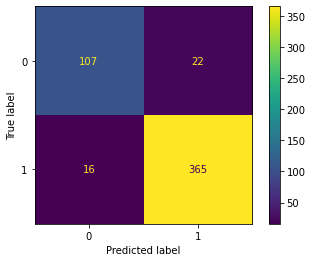

In [35]:
cm = confusion_matrix(test_label, test_pred_dt)
plot_confusion_matrix(dt_grid, test_set, test_label)
plt.show() 

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

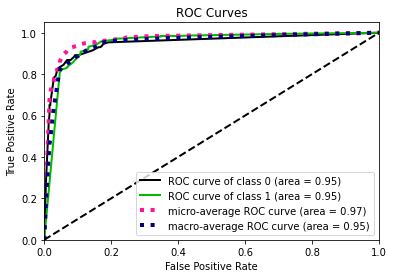

In [36]:
test_pred_proba_dt = dt_grid.predict_proba(test_set)
skplt.metrics.plot_roc(test_label, test_pred_proba_dt)

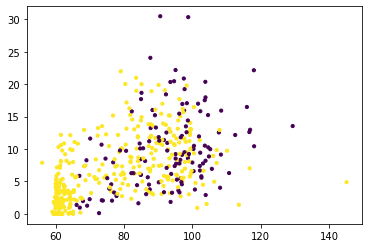

In [37]:
#ace and minutes
plt.scatter(test_set['minutes'], test_set['perc_ace'], c=test_label, s=10);

## Bayesian classifier

In [38]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [39]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)
train_pred_gnb = gnb.predict(train_set)
#predict on the test set
test_pred_gnb = gnb.predict(test_set)

In [40]:
#compute the performance of the model
print(classification_report(train_label, train_pred_gnb, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.66      0.92      0.77       387
   low-level       0.97      0.84      0.90      1140

    accuracy                           0.86      1527
   macro avg       0.81      0.88      0.83      1527
weighted avg       0.89      0.86      0.86      1527



In [41]:
print(classification_report(test_label, test_pred_gnb, target_names=class_names))

              precision    recall  f1-score   support

  high-level       0.72      0.93      0.81       129
   low-level       0.97      0.88      0.92       381

    accuracy                           0.89       510
   macro avg       0.85      0.90      0.87       510
weighted avg       0.91      0.89      0.90       510



<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

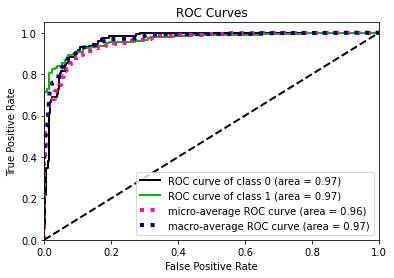

In [42]:
test_pred_proba_gnb = gnb.predict_proba(test_set)
test_pred_proba_gnb
skplt.metrics.plot_roc(test_label, test_pred_proba_gnb)

### 

## Neural Network

In [43]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

Init Plugin
Init Graph Optimizer
Init Kernel


In [44]:
def create_model(n_neurons1, activation1, n_neurons2, activation2, dropout_rate, optimizer, activation_out, loss): 
    # create model
    model = Sequential()
    model.add(Dense(n_neurons1, input_dim=19, activation=activation1)) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_neurons2, activation=activation2))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(1, activation=activation_out))
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy", "MeanSquaredError"])
    return model

In [45]:
grid_param = {
    "n_neurons1":[9,20],
    "activation1":["sigmoid","softmax","linea"],
    "n_neurons2":[5,15],
    "activation2":["relu","softmax"],
    "optimizer": ['SGD'],
#     "activation_out":["softmax","relu","sigmoid"],
    "dropout_rate" : [0.2],
    "activation_out":["softmax"],
    "loss":["binary_crossentropy", "mean_squared_error"]
}

nn = KerasClassifier(build_fn=create_model, epochs=150, batch_size=32)
nn_grid = GridSearchCV(nn, param_grid=grid_param, n_jobs=-1, cv=5, scoring=make_scorer(f1_score))


In [46]:
start = time.time()
best_model = nn_grid.fit(train_set, train_label)
print(nn_grid.best_params_)
train_pred_nn = nn_grid.predict(train_set)
test_pred_nn = nn_grid.predict(test_set)
print('Time taken for fit: {} sec\n'.format(time.time() - start))

Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Init Plugin
Init Graph Optimizer
Init Kernel
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1
Metal device set to: Apple M1


2021-12-23 19:29:10.411022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-23 19:29:10.411028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-23 19:29:10.411045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-23 19:29:10.411022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-23 19:29:10.411080: I tensorflow/core/common_runtime/plu

Epoch 1/150
39/39 [==============================] - 1s 17ms/step - loss: 0.6378 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 3/150
39/39 [==============================] - 1s 18ms/step - loss: 0.5774 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 3/150
39/39 [==============================] - 1s 34ms/step - loss: 0.5884 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 5/150
39/39 [==============================] - 1s 36ms/step - loss: 0.6140 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 4/150
28/39 [====================>.........] - ETA: 0s - loss: 0.6294 - accuracy: 0.7288 - mean_squared_error: 0.2712Epoch 5/150


39/39 [==============================] - 1s 27ms/step - loss: 0.5879 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 7/150
39/39 [==============================] - 1s 31ms/step - loss: 0.5332 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 8/150
39/39 [==============================] - 1s 26ms/step - loss: 0.5530 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 10/150
39/39 [==============================] - 1s 32ms/step - loss: 0.5248 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 10/150
 1/39 [..............................] - ETA: 0s - loss: 0.5494 - accuracy: 0.7188 - mean_squared_error: 0.2812Epoch 11/150


39/39 [==============================] - 2s 39ms/step - loss: 0.5988 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 14/150
 8/39 [=====>........................] - ETA: 0s - loss: 0.5586 - accuracy: 0.7305 - mean_squared_error: 0.2695Epoch 15/150


39/39 [==============================] - 1s 33ms/step - loss: 0.5308 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 15/150
39/39 [==============================] - 1s 36ms/step - loss: 0.5745 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 16/150
39/39 [==============================] - 1s 35ms/step - loss: 0.5888 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 16/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5750 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 16/150
39/39 [==============================] - 1s 31ms/step - loss: 0.5154 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 19/150


39/39 [==============================] - 1s 30ms/step - loss: 0.5679 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 21/150
39/39 [==============================] - 1s 33ms/step - loss: 0.5848 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 22/150
 7/39 [====>.........................] - ETA: 0s - loss: 0.5883 - accuracy: 0.7500 - mean_squared_error: 0.2500Epoch 25/150


39/39 [==============================] - 2s 42ms/step - loss: 0.5659 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 27/150
39/39 [==============================] - 1s 39ms/step - loss: 0.5079 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 25/150
 8/39 [=====>........................] - ETA: 1s - loss: 0.5431 - accuracy: 0.7500 - mean_squared_error: 0.2500Epoch 28/150


39/39 [==============================] - 1s 36ms/step - loss: 0.5657 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 30/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5222 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 31/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5498 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 31/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5033 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 30/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5057 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 33/150
39/39 [==============================] - 1s 27ms/step - loss: 0.4789 - accuracy: 0.7471 - mean_squared_error: 0.2529


39/39 [==============================] - 1s 25ms/step - loss: 0.4968 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 35/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5712 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 35/150
39/39 [==============================] - 1s 28ms/step - loss: 0.4863 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 37/150
39/39 [==============================] - 1s 27ms/step - loss: 0.5647 - accuracy: 0.7543 - mean_squared_error: 0.2457


39/39 [==============================] - 1s 26ms/step - loss: 0.5616 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 41/150
39/39 [==============================] - 1s 23ms/step - loss: 0.5620 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 39/150
39/39 [==============================] - 1s 32ms/step - loss: 0.4966 - accuracy: 0.7543 - mean_squared_error: 0.2457


39/39 [==============================] - 1s 27ms/step - loss: 0.5630 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 42/150
39/39 [==============================] - 1s 31ms/step - loss: 0.5011 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 45/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5707 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 43/150
39/39 [==============================] - 1s 26ms/step - loss: 0.5039 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 46/150
39/39 [==============================] - 1s 29ms/step - loss: 0.4791 - accuracy: 0.7471 - mean_squared_error: 0.2529


39/39 [==============================] - 1s 27ms/step - loss: 0.5668 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 49/150
39/39 [==============================] - 1s 30ms/step - loss: 0.4850 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 49/150
39/39 [==============================] - 1s 27ms/step - loss: 0.5693 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 48/150
18/39 [============>.................] - ETA: 0s - loss: 0.5878 - accuracy: 0.7240 - mean_squared_error: 0.2760Epoch 52/150


39/39 [==============================] - 1s 31ms/step - loss: 0.5741 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 51/150
39/39 [==============================] - 1s 32ms/step - loss: 0.5681 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 53/150
39/39 [==============================] - 1s 32ms/step - loss: 0.5452 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 56/150
39/39 [==============================] - 1s 27ms/step - loss: 0.5616 - accuracy: 0.7543 - mean_squared_error: 0.2457


39/39 [==============================] - 1s 34ms/step - loss: 0.5352 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 57/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5663 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 57/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5414 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 55/150
39/39 [==============================] - 1s 27ms/step - loss: 0.5688 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 58/150
39/39 [==============================] - 1s 23ms/step - loss: 0.4899 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 59/150
33/39 [========================>.....] - ETA: 0s - loss: 0.5653 - accuracy: 0.7528 - mean_squared_error: 0.2472Epoch 57/150


39/39 [==============================] - 1s 22ms/step - loss: 0.5612 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 60/150
39/39 [==============================] - 1s 27ms/step - loss: 0.5918 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 62/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5645 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 63/150
39/39 [==============================] - 1s 23ms/step - loss: 0.5382 - accuracy: 0.7453 - mean_squared_error: 0.2547


39/39 [==============================] - 1s 28ms/step - loss: 0.5011 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 65/150
39/39 [==============================] - 1s 27ms/step - loss: 0.5844 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 66/150
39/39 [==============================] - 1s 24ms/step - loss: 0.5645 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 67/150
39/39 [==============================] - 1s 26ms/step - loss: 0.5602 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 69/150
20/39 [==============>...............] - ETA: 0s - loss: 0.5592 - accuracy: 0.7375 - mean_squared_error: 0.2625Epoch 67/150


39/39 [==============================] - 1s 26ms/step - loss: 0.5720 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 66/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5320 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 69/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5249 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 69/150
 1/39 [..............................] - ETA: 0s - loss: 0.4766 - accuracy: 0.7500 - mean_squared_error: 0.2500Epoch 74/150


39/39 [==============================] - 1s 30ms/step - loss: 0.5197 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 74/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5670 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 75/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5709 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 76/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5708 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 79/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5287 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 75/150
39/39 [==============================] - 1s 25ms/step - loss: 0.5632 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 73/150
39/39 [==============================] - 1s 25ms/step - loss: 0.5670 - accuracy: 0.7463 - mean_squared_error: 0.2537


39/39 [==============================] - 1s 28ms/step - loss: 0.5637 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 79/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5664 - accuracy: 0.7543 - mean_squared_error: 0.2457


39/39 [==============================] - 1s 27ms/step - loss: 0.5690 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 81/150
39/39 [==============================] - 1s 24ms/step - loss: 0.5330 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 85/150
39/39 [==============================] - 1s 29ms/step - loss: 0.4813 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 85/150
39/39 [==============================] - 1s 36ms/step - loss: 0.5749 - accuracy: 0.7463 - mean_squared_error: 0.2537


39/39 [==============================] - 1s 33ms/step - loss: 0.5642 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 90/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5333 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 91/150
39/39 [==============================] - 1s 32ms/step - loss: 0.5617 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 95/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5656 - accuracy: 0.7543 - mean_squared_error: 0.2457


39/39 [==============================] - 1s 30ms/step - loss: 0.5589 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 92/150
39/39 [==============================] - 1s 26ms/step - loss: 0.5684 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 94/150
39/39 [==============================] - 1s 24ms/step - loss: 0.5580 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 99/150
19/39 [=============>................] - ETA: 0s - loss: 0.4872 - accuracy: 0.7566 - mean_squared_error: 0.2434Epoch 94/150


39/39 [==============================] - 1s 33ms/step - loss: 0.4849 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 105/150
 4/39 [==>...........................] - ETA: 0s - loss: 0.6013 - accuracy: 0.7188 - mean_squared_error: 0.2812Epoch 101/150


39/39 [==============================] - 1s 34ms/step - loss: 0.4793 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 97/150
39/39 [==============================] - 1s 31ms/step - loss: 0.5604 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 102/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5616 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 105/150
39/39 [==============================] - 1s 26ms/step - loss: 0.5715 - accuracy: 0.7463 - mean_squared_error: 0.2537


39/39 [==============================] - 1s 33ms/step - loss: 0.5606 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 106/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5677 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 106/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5364 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 113/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5714 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 108/150
39/39 [==============================] - 1s 27ms/step - loss: 0.5574 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 110/150
 1/39 [..............................] - ETA: 0s - loss: 0.5537 - accuracy: 0.7500 - mean_squared_error: 0.2500Epoch 107/150


39/39 [==============================] - 1s 28ms/step - loss: 0.5676 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 110/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5089 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 117/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5672 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 107/150
39/39 [==============================] - 1s 26ms/step - loss: 0.5681 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 111/150
39/39 [==============================] - 1s 24ms/step - loss: 0.4936 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 113/150
39/39 [==============================] - 1s 32ms/step - loss: 0.5490 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 113/150
32/39 [=======================>......] - ETA: 0s - loss: 0.5605 - accuracy: 0.7549 - mean_squared_error: 0.2451Epoch 114/150


39/39 [==============================] - 1s 31ms/step - loss: 0.5697 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 112/150
 6/39 [===>..........................] - ETA: 0s - loss: 0.6284 - accuracy: 0.6979 - mean_squared_error: 0.3021Epoch 116/150


39/39 [==============================] - 1s 27ms/step - loss: 0.4806 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 117/150
39/39 [==============================] - 1s 34ms/step - loss: 0.5618 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 119/150
39/39 [==============================] - 1s 34ms/step - loss: 0.5208 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 120/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5605 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 120/150
29/39 [=====================>........] - ETA: 0s - loss: 0.4959 - accuracy: 0.7414 - mean_squared_error: 0.2586Epoch 130/150


39/39 [==============================] - 1s 33ms/step - loss: 0.5609 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 122/150
39/39 [==============================] - 1s 26ms/step - loss: 0.5207 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 125/150
39/39 [==============================] - 1s 36ms/step - loss: 0.5212 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 127/150
39/39 [==============================] - 2s 40ms/step - loss: 0.5676 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 125/150
10/39 [======>.......................] - ETA: 1s - loss: 0.5583 - accuracy: 0.7531 - mean_squared_error: 0.2469Epoch 125/150


39/39 [==============================] - 3s 68ms/step - loss: 0.4731 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 125/150
39/39 [==============================] - 2s 53ms/step - loss: 0.4976 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 131/150
14/39 [=========>....................] - ETA: 0s - loss: 0.4730 - accuracy: 0.7344 - mean_squared_error: 0.2656Epoch 132/150


39/39 [==============================] - 2s 41ms/step - loss: 0.4716 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 128/150
39/39 [==============================] - 2s 51ms/step - loss: 0.5670 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 133/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5663 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 133/150
39/39 [==============================] - 1s 29ms/step - loss: 0.4727 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 131/150
39/39 [==============================] - 1s 36ms/step - loss: 0.5701 - accuracy: 0.7463 - mean_squared_error: 0.2537


Epoch 132/150
39/39 [==============================] - 1s 35ms/step - loss: 0.4727 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 135/150
39/39 [==============================] - 2s 39ms/step - loss: 0.4711 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 135/150
39/39 [==============================] - 1s 30ms/step - loss: 0.5582 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 148/150
 5/39 [==>...........................] - ETA: 1s - loss: 0.4419 - accuracy: 0.7688 - mean_squared_error: 0.2313Epoch 149/150


26/39 [===================>..........] - ETA: 0s - loss: 0.5482 - accuracy: 0.7644 - mean_squared_error: 0.2356

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


39/39 [==============================] - 1s 27ms/step - loss: 0.5112 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 142/150
14/39 [=========>....................] - ETA: 0s - loss: 0.4440 - accuracy: 0.7656 - mean_squared_error: 0.2344

2021-12-23 19:32:08.034454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/39 [====================>.........] - ETA: 0s - loss: 0.4869 - accuracy: 0.7411 - mean_squared_error: 0.2589

2021-12-23 19:32:10.930979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 38ms/step - loss: 0.5674 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 146/150
39/39 [==============================] - 1s 34ms/step - loss: 0.4747 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 147/150
39/39 [==============================] - 1s 28ms/step - loss: 0.5671 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 145/150
39/39 [==============================] - 1s 33ms/step - loss: 0.4784 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 148/150
39/39 [==============================] - 1s 34ms/step - loss: 0.4795 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 149/150
39/39 [==============================] - 1s 35ms/step - loss: 0.4799 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 148/150
39/39 [==============================] - 1s 31ms/step - loss: 0.4674 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 150/150
18/39 [============>.................] - ETA: 0s - loss: 0.5619 - accuracy: 0.7500 

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


36/39 [==========================>...] - ETA: 0s - loss: 0.4689 - accuracy: 0.7405 - mean_squared_error: 0.2595

2021-12-23 19:32:17.083077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/39 [===========>..................] - ETA: 0s - loss: 0.4676 - accuracy: 0.7500 - mean_squared_error: 0.2500

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


21/39 [===============>..............] - ETA: 0s - loss: 0.4916 - accuracy: 0.7351 - mean_squared_error: 0.2649

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-23 19:32:17.876228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/39 [==========>...................] - ETA: 0s - loss: 0.5605 - accuracy: 0.7542 - mean_squared_error: 0.2458

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-23 19:32:18.104305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 29ms/step - loss: 0.4698 - accuracy: 0.7463 - mean_squared_error: 0.2537
Epoch 150/150
25/39 [==================>...........] - ETA: 0s - loss: 0.6009 - accuracy: 0.7375 - mean_squared_error: 0.2625

2021-12-23 19:32:18.542696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/39 [===========>..................] - ETA: 0s - loss: 0.5851 - accuracy: 0.7305 - mean_squared_error: 0.2695

2021-12-23 19:32:19.133380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


28/39 [====================>.........] - ETA: 0s - loss: 0.5463 - accuracy: 0.7667 - mean_squared_error: 0.2333

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


39/39 [==============================] - 1s 25ms/step - loss: 0.5683 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 149/150
 4/39 [==>...........................] - ETA: 1s - loss: 0.6012 - accuracy: 0.7109 - mean_squared_error: 0.2891

2021-12-23 19:32:19.780332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 5/39 [==>...........................] - ETA: 1s - loss: 0.5551 - accuracy: 0.7812 - mean_squared_error: 0.2188

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-23 19:32:20.030657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-23 19:32:20.157329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


16/39 [===========>..................] - ETA: 0s - loss: 0.5822 - accuracy: 0.7559 - mean_squared_error: 0.2441

2021-12-23 19:32:20.316307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-23 19:32:20.324987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/39 [=============>................] - ETA: 0s - loss: 0.5750 - accuracy: 0.7516 - mean_squared_error: 0.2484

2021-12-23 19:32:21.242938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/39 [..............................] - ETA: 1:38 - loss: 0.6411 - accuracy: 0.7500 - mean_squared_error: 0.2500

/Users/domenico/miniforge3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2021-12-23 19:32:21.671085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 23ms/step - loss: 0.5826 - accuracy: 0.7471 - mean_squared_error: 0.2529
Epoch 10/150
 5/39 [==>...........................] - ETA: 0s - loss: 0.5320 - accuracy: 0.7875 - mean_squared_error: 0.2125

2021-12-23 19:32:21.866499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 4s 46ms/step - loss: 0.7036 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 2/150
 1/39 [..............................] - ETA: 0s - loss: 0.6961 - accuracy: 0.6250 - mean_squared_error: 0.3750

2021-12-23 19:32:23.455374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 1s 33ms/step - loss: 0.6348 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 3/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5990 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 6/150
30/39 [======================>.......] - ETA: 0s - loss: 0.6035 - accuracy: 0.7458 - mean_squared_error: 0.2542Epoch 7/150


39/39 [==============================] - 1s 36ms/step - loss: 0.5702 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 3/150
39/39 [==============================] - 1s 36ms/step - loss: 0.5414 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 10/150
39/39 [==============================] - 1s 29ms/step - loss: 0.5749 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 4/150
39/39 [==============================] - 1s 33ms/step - loss: 0.5007 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 12/150
39/39 [==============================] - 1s 34ms/step - loss: 0.5262 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 11/150
 4/39 [==>...........................] - ETA: 1s - loss: 0.6274 - accuracy: 0.6797 - mean_squared_error: 0.3203Epoch 12/150


39/39 [==============================] - 1s 29ms/step - loss: 0.5373 - accuracy: 0.7398 - mean_squared_error: 0.2602
Epoch 11/150
39/39 [==============================] - 1s 33ms/step - loss: 0.4941 - accuracy: 0.7543 - mean_squared_error: 0.2457
Epoch 13/150
39/39 [==============================] - 1s 35ms/step - loss: 0.5421 - accuracy: 0.7453 - mean_squared_error: 0.2547
Epoch 6/150
33/39 [========================>.....] - ETA: 0s - loss: 0.5219 - accuracy: 0.7491 - mean_squared_error: 0.2509

KeyboardInterrupt: 

In [ ]:
print(classification_report(train_label, train_pred_nn, target_names=class_names))

In [ ]:
print(classification_report(test_label, test_pred_nn, target_names=class_names))

### Accuracy

In [ ]:
best_nn=best_model.best_estimator_
history=best_nn.fit(train_set.values, train_label,
                    epochs=120,
                    batch_size=32,
                    validation_split=0.2)

### Print accuracy of best models

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy', c='r')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='b')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Print accuracy of best models

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss', c='r')
plt.plot(epochs, val_loss, 'b', label='Validation Loss', c='b')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
train_set_no_cat = train_set.loc[:,~train_set.columns.str.contains('_num', case=False)] 
test_set_no_cat = test_set.loc[:,~test_set.columns.str.contains('_num', case=False)] 

k = math.sqrt(len(train_set))
k = round(k, 0)
k = int(k)
k = k - 2
k_range = []
for i in range(0,5):
    k_range.append(k)
    k = k + 1
k_range

In [ ]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }

knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring=make_scorer(f1_score))

In [ ]:
knn_grid.fit(train_set_no_cat, train_label)

In [ ]:
train_pred_knn = knn_grid.predict(train_set_no_cat)
test_pred_knn = knn_grid.predict(test_set_no_cat)

In [ ]:
print(classification_report(train_label, train_pred_knn, target_names=class_names))

In [ ]:
print(classification_report(test_label, test_pred_knn, target_names=class_names))